# Two Layer Neural Net
Autor: Gabriel Dornelles Monteiro, março de 2022. Notebook nº3.

Ao fim deste notebook, você deve ser capaz de entender bem o processo de otimização de neural nets em blocos, e também compreender os processos e cálculos realizados. 

Neste notebook iremos evoluir nosso Softmax Classifier, que possuia apenas 10 neurônios, para isso iremos adicionar uma nova camada com 100 neurônios, e introduziremos a função de ativação ReLU.

Também iremos começar trabalhar em batches para o treinamento, além de tratar o código de uma maneira mais organizada. Ao fim visualizaremos os pesos aprendidos e vamos entender quais foram as melhoras e quais ainda são nossas limitações.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [2]:
# Boilerplate do notebook anterior
train_dataset = CIFAR10(root="./", download=True, train=True) 
val_dataset = CIFAR10(root="./", download=True, train=False) 

train_images = np.array([np.array(train_dataset[i][0]) for i in range(len(train_dataset))])
train_targets = np.array([np.array(train_dataset[i][1]) for i in range(len(train_dataset))])

val_images = np.array([np.array(val_dataset[i][0]) for i in range(len(val_dataset))])
val_targets = np.array([np.array(val_dataset[i][1]) for i in range(len(val_dataset))])

# transforma nossas imagens 32x32x3 em vetor linha 3072
train_images = np.reshape(train_images, (train_images.shape[0], -1))
val_images = np.reshape(val_images, (val_images.shape[0], -1))

# média do array train_images no eixo 0, eixo onde os índices são as imagens 3072
mean_image = np.mean(train_images, axis = 0)

# mean_image é um array de floats, para operação fazer sentido nossas imagens precisam ser também.
train_images = train_images.astype(float)
train_images -= mean_image

val_images = val_images.astype(float)
val_images -= mean_image
# train_images shape: (50000, 3072)

Files already downloaded and verified
Files already downloaded and verified


# Gradientes
Temos duas operações diferentes das utilizadas e explicadas no ultimo notebook, o Bias, e a função de ativação ReLU.

Para melhor visualização adicione a extensão markdown+math no vscode, ou utilize qualquer renderizador para as expressões.

Alternativa online: https://arachnoid.com/latex/

## Gradiente de termo Bias
O bias é uma operação de adição a matriz de pesos (W+b).

O gradiente do termo Bias é dado por
$$\frac{∂L}{∂b}=\frac{∂L}{∂W} \frac{∂W}{∂b} $$

Como vimos anteriormente, a derivada local da operação de soma é 1, como estamos operando um array, a derivada local do nosso termo bias é um vetor de 1s.
$$ \frac{∂W}{∂b} = [1,1,1,1,1,...,1] $$


Isso significa que efetivamente, utilizando a regra da cadeia, a operação que realizamos é:

$$\frac{∂L}{∂b}=\frac{∂L}{∂W} * [1,1,1,1,1,...,1] $$

O que é na verdade, já que todos elementos do array são 1, a soma das linhas da matriz W (já que todas serão multiplicadas por 1 e somadas umas as outras). 

Por este motivo, o código que vemos no backward do nosso modelo está assim:
```py
db = dW.sum(axis=0) # Onde dW é o gradiente fluindo no gate da operação resultante de X@W+b
```

## Gradiente da função ReLU
A função ReLU(Rectfied Linear Unit) é dada por:
$$ f(x) = max(0,x) $$

E sua derivada é dada 0 quando x<=0, e 1 quando x>1. Dessa maneira, o gradiente é calculado como:
```py
local_gradient = relu_fc>0 # True para os valores maiores que 0, False para os menores ou iguais a 0
global_gradient = dW # gradiente fluindo de volta para o gate
drelu = global_gradient@local_gradient
```


# Criando nosso modelo
Nosso modelo sera uma rede de duas camadas, formalmente descrevemos como: $$ f(x) = softmax((max(0, X*W1+b1))*(W2+b2))$$

Onde teremos W1, nossa matriz de pesos 3072xN, onde N é o numero de neurônios que desejamos ter (100, 1000 etc), e b1, seu bias.

E W2, nossa matriz Nx10, que irá transformar os neurônios da camada anterior para nossas probabilidades junto a b2, seu bias.

O grafo de nosso modelo fica desta maneira:

![image](https://user-images.githubusercontent.com/56324869/160459741-28ab0f12-8830-4212-affa-06ffb7b6d293.png)



In [22]:
class TwoLayerNeuralNet:

    def __init__(self, input_size, hidden_size, output_size, std=1e-4, reg=1.5e-1):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        self.reg = reg
    
    @staticmethod
    def softmax(scores):
        scores -= np.max(scores, axis=1, keepdims=True)
        scores_exp = np.exp(scores)
        softmax_matrix = scores_exp / np.sum(scores_exp, axis=1, keepdims=True) 
        return softmax_matrix
    
    def predict(self, X):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        fc1 = X@W1 + b1 # input to fc
        relu_fc = np.maximum(0, fc1) # fc to relu-fc
        scores = relu_fc@W2 + b2 # relu-fc to output
        softmax = self.softmax(scores) # softmax
        y_pred = np.argmax(softmax, axis=1) # batch of predictions
        return y_pred
    
    def val(self, X, y):
        return (self.predict(X) == y).mean()
    
    def forward(self, X, grad = True):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
    
        fc = X@W1 + b1 # fully connected
        relu_fc = np.maximum(0, fc) # ReLU
        scores = relu_fc@W2 + b2 # fully connected
        softmax = self.softmax(scores) # softmax

        if grad:
            self.W1, self.W2, self.fc, self.relu_fc = W1, W2, fc, relu_fc

        return softmax

    def loss(self, X, y, reg=0.0):
        self.num_train, D = X.shape
        self.softmax_matrix = self.forward(X)
        loss = np.sum(-np.log(self.softmax_matrix[np.arange(self.num_train), y]))
        loss /= self.num_train
        loss += reg * (np.sum(self.W2 * self.W2) + np.sum( self.W1 * self.W1 )) # regularization
        return loss
    
    def backward(self, X, y):
        softmax_matrix = self.softmax_matrix
        softmax_matrix[np.arange(self.num_train) ,y] -= 1 
        softmax_matrix /= self.num_train 
        dW2 = (self.relu_fc.T)@(softmax_matrix) #
        db2 = softmax_matrix.sum(axis=0)
        dW1 = (softmax_matrix)@(self.W2.T)   
        dfc = dW1 * (self.fc>0)            
        dW1 = (X.T)@(dfc)            
        db1 = dfc.sum(axis=0) 
        # regularization gradient
        dW1 += self.reg * 2 * self.W1
        dW2 += self.reg * 2 * self.W2
        grads = {'W1':dW1, 'b1':db1, 'W2':dW2, 'b2':db2}
        return grads
    
    def train(self, X, y, X_val, y_val, lr=1e-3, epoches=100, batch_size = 256):
        num_train = X.shape[0]
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for epoch in range(epoches):
            batch_indices = np.random.choice(num_train, batch_size)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            loss = self.loss(X_batch,y_batch)
            grads = self.backward(X_batch,y_batch)

            # update
            for key in self.params:
                self.params[key] -= lr * grads[key]
            train_acc = self.val(X_batch,y_batch)
            val_acc = self.val(X_val, y_val)

            # save metrics
            loss_history.append(loss)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            if epoch%100==0:
                print(f"Epoch {epoch}\n    Loss: {loss}\n    Train acc: {train_acc}\n    Val acc: {val_acc}\n")
        return {
        'loss_history': loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        }

In [23]:
model = TwoLayerNeuralNet(input_size=3072, hidden_size=100, output_size=10)
statistics = model.train(X=train_images, y=train_targets, X_val=val_images, y_val=val_targets, epoches=1000)

Epoch 0
    Loss: 2.3026115479059346
    Train acc: 0.12890625
    Val acc: 0.1158

Epoch 100
    Loss: 1.8783938586170232
    Train acc: 0.3046875
    Val acc: 0.3058

Epoch 200
    Loss: 1.7007566486977133
    Train acc: 0.4296875
    Val acc: 0.3756

Epoch 300
    Loss: 1.6437749829708814
    Train acc: 0.4609375
    Val acc: 0.4155

Epoch 400
    Loss: 1.6090573731765698
    Train acc: 0.5234375
    Val acc: 0.4367

Epoch 500
    Loss: 1.575393111306723
    Train acc: 0.53515625
    Val acc: 0.4467

Epoch 600
    Loss: 1.6038218972824523
    Train acc: 0.5078125
    Val acc: 0.4598

Epoch 700
    Loss: 1.328990474976813
    Train acc: 0.60546875
    Val acc: 0.4684

Epoch 800
    Loss: 1.457121205847896
    Train acc: 0.578125
    Val acc: 0.4821

Epoch 900
    Loss: 1.3465337520447231
    Train acc: 0.609375
    Val acc: 0.4801



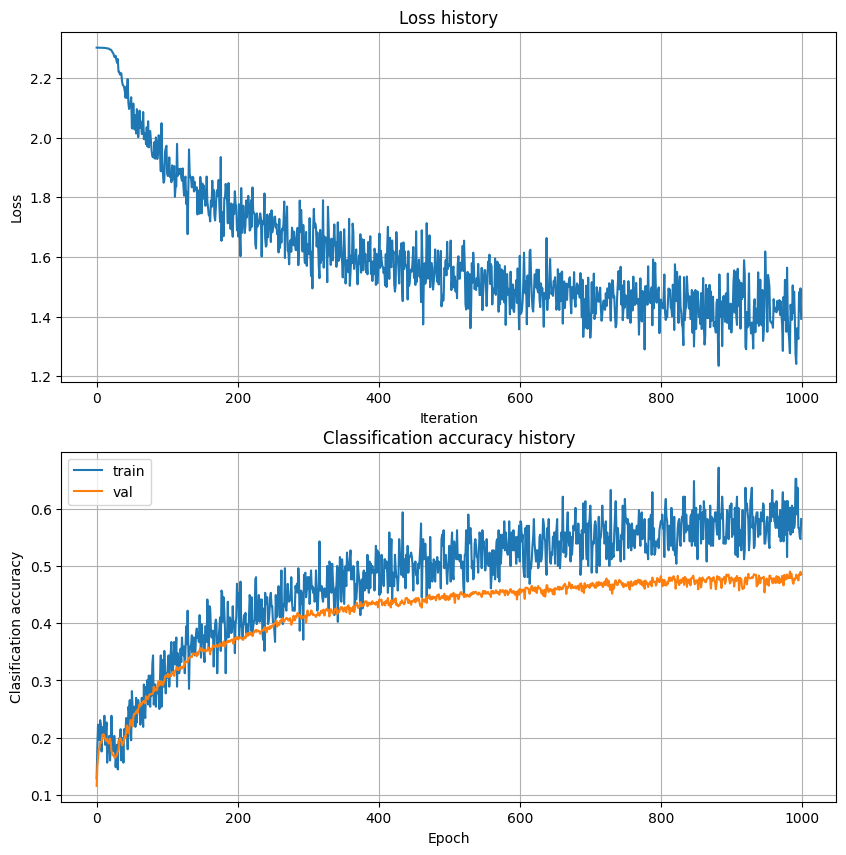

In [24]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10,10), dpi=100)

plt.subplot(2, 1, 1)
plt.plot(statistics['loss_history'])
plt.title('Loss history')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(statistics['train_acc_history'], label='train')
plt.plot(statistics['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [25]:
from math import ceil, sqrt
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.
  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

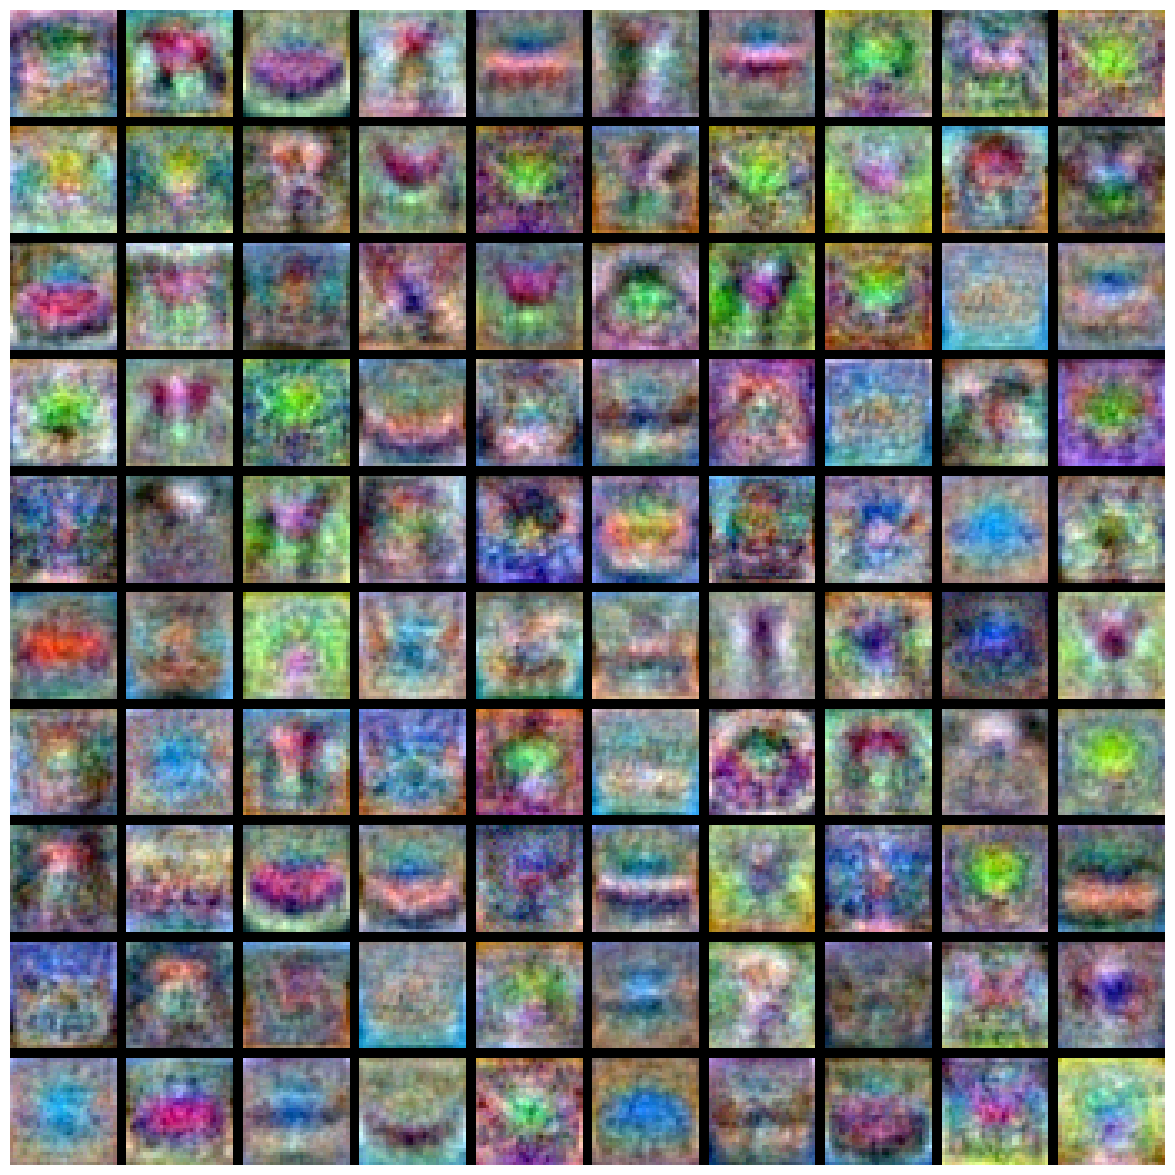

In [26]:
figure(figsize=(15,15), dpi=100)
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)